Enter the path to the test data file: test.csv
Dataset loaded successfully from train.csv.
Dataset loaded successfully from test.csv.
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1

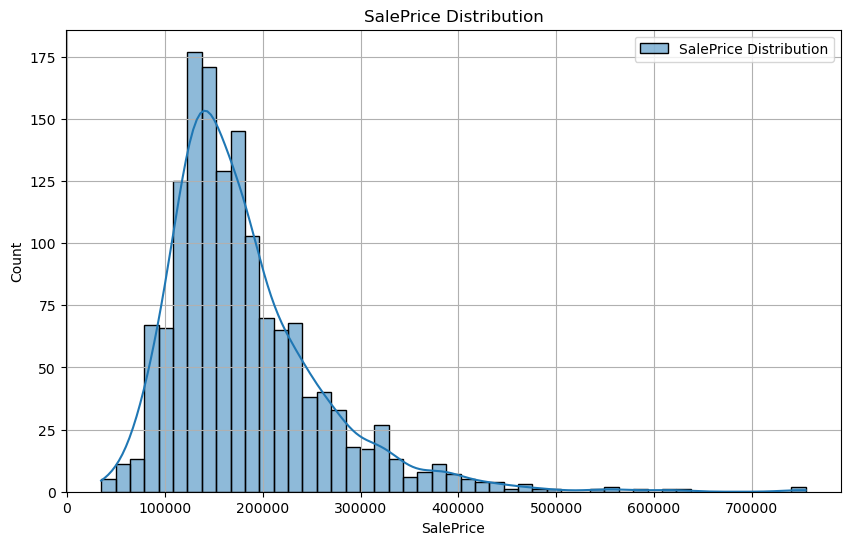

Model trained successfully.
Mean Squared Error: 835830635.1033542
Root Mean Squared Error: 28910.73563753358
R-squared: 0.8910306273128021


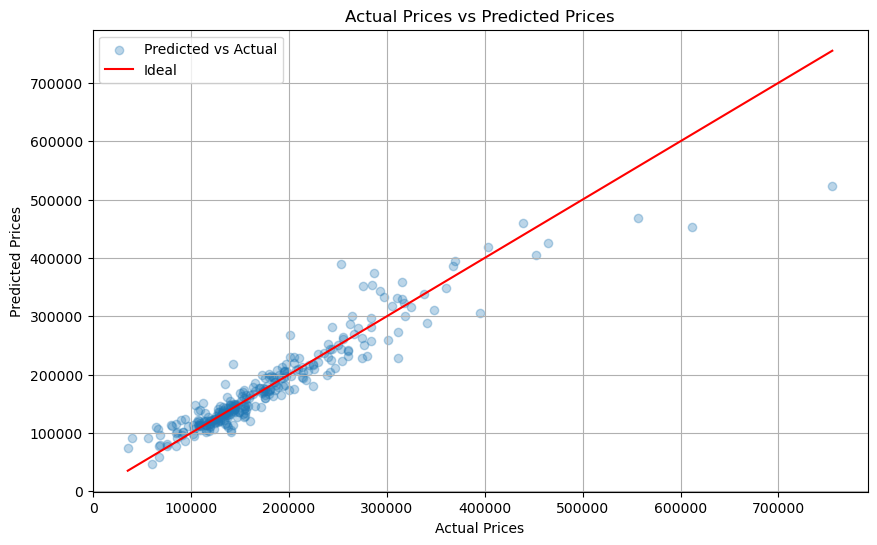

Predictions saved to predictions.csv.


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Function to load dataset
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"Dataset loaded successfully from {file_path}.")
        return data
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None

# Function to preprocess data (drop unnecessary columns and encode categorical variables)
def preprocess_data(train_data, test_data):
    # Drop 'Id' column if present
    if 'Id' in train_data.columns:
        train_data.drop(['Id'], axis=1, inplace=True)
    if 'Id' in test_data.columns:
        test_data.drop(['Id'], axis=1, inplace=True)
    
    # Combine train and test data for consistent preprocessing
    train_data['is_train'] = 1
    test_data['is_train'] = 0
    combined_data = pd.concat([train_data, test_data])
    
    # One-hot encode categorical variables
    combined_data = pd.get_dummies(combined_data)
    
    # Separate combined data back into train and test sets
    train_data = combined_data[combined_data['is_train'] == 1].drop(['is_train'], axis=1)
    test_data = combined_data[combined_data['is_train'] == 0].drop(['is_train'], axis=1)
    
    return train_data, test_data

# Function to train a HistGradientBoostingRegressor model
def train_model(X_train, y_train, random_state):
    model = HistGradientBoostingRegressor(random_state=random_state)
    model.fit(X_train, y_train)
    print("Model trained successfully.")
    return model

# Function to evaluate model performance and make predictions
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Ensure non-negative predictions
    y_pred = np.maximum(y_pred, 0)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    # Visualize predicted vs actual prices
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual Prices vs Predicted Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return y_pred

# Function to make predictions on new data
def predict_new_data(model, test_data, train_columns):
    # Ensure test data has the same columns as training data
    test_data = test_data.reindex(columns=train_columns, fill_value=0)
    
    # Make predictions
    y_pred = model.predict(test_data)
    
    # Ensure non-negative predictions
    y_pred = np.maximum(y_pred, 0)
    
    return y_pred

# Function to save predictions to a CSV file
def save_predictions(predictions, test_data, file_path):
    # Ensure 'Id' column is available or generate a default index-based identifier
    if 'Id' in test_data.columns:
        ids = test_data['Id']
    else:
        ids = range(1, len(predictions) + 1)  # Generate default ids
    
    predictions_df = pd.DataFrame({'Id': ids, 'PredictedPrice': predictions})
    predictions_df.to_csv(file_path, index=False)
    print(f'Predictions saved to {file_path}.')

# Function to display data statistics and distributions
def explore_data(data):
    print(data.describe())
    plt.figure(figsize=(10, 6))
    sns.histplot(data['SalePrice'], kde=True, label='SalePrice Distribution')
    plt.title('SalePrice Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to orchestrate the entire process
def main(test_file, predictions_file, train_file='train.csv', random_state=42):
    # Load training and test data
    train_data = load_data(train_file)
    test_data = load_data(test_file)

    if train_data is None or test_data is None:
        return

    # Explore training data
    explore_data(train_data)

    # Preprocess data (drop unnecessary columns and encode categorical variables)
    y = train_data['SalePrice']
    X = train_data.drop(columns=['SalePrice'])
    X_test = test_data

    # Preprocess combined data to ensure consistent column structure
    X, X_test = preprocess_data(X, X_test)

    # Handle missing values with SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    # Scale the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Train the model
    model = train_model(X_train, y_train, random_state)

    # Evaluate the model
    evaluate_model(model, X_val, y_val)

    # Make predictions on test data
    predictions = predict_new_data(model, X_test, X.columns)

    # Save predictions to a CSV file
    save_predictions(predictions, test_data, predictions_file)

# Execute the main function with file paths
test_file = input("Enter the path to the test data file: ")
predictions_file = 'predictions.csv'

main(test_file, predictions_file)

